Consider sampling a target mixture distribution

In [8]:
import beanmachine.ppl as bm
import torch
import torch.distributions as dist

@bm.random_variable
def x():
    return dist.MixtureSameFamily(
        dist.Categorical(probs=torch.tensor(
            [0.3, 0.3, 0.4]
        )),
        dist.Independent(dist.Normal(
            torch.tensor([-0., 5., 15.]),
            torch.tensor([1.0, 1.0, 0.5]),
        ), 0)
    )


Without conditioning, ancestral sampling gives a direct sampling algorithm

,avg,std,2.5%,50%,97.5%,n_eff
x()[],7.486353,6.518468,-1.426089,5.355861,15.732247,1051.021606


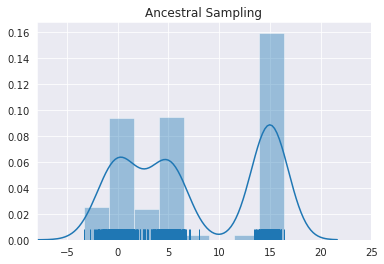

In [12]:
import seaborn as sns
sns.set_style("darkgrid")

samples = bm.SingleSiteAncestralMetropolisHastings().infer(
    [x()],
    {},
    num_samples=1000,
    num_chains=1,
)
fig = sns.distplot(samples[x()], rug=True)
fig.set_title("Ancestral Sampling")
fig.set(xlim=(-8,25))

bm.Diagnostics(samples).summary()

In [13]:
import numpy as np
import pandas as pd
from scipy import signal
def acf(samples):
    xs = samples[x()][0].numpy()
    acs = signal.fftconvolve(xs, xs[::-1], mode='full')
    f = sns.relplot(
        data=pd.DataFrame({
            'lag': np.arange(-len(xs)+1,len(xs)),
            'autocorr': acs,
        }), x='lag', y='autocorr')
    return f

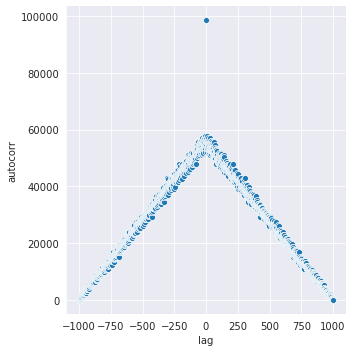

In [14]:
acf(samples)

NMC, due to locality of Hessian, should get stuck in the mode it is initialized in (closest to 0).

Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to Eigen decomposition.
Error: Cholesky decomposition failed. Falls back to

,avg,std,2.5%,50%,97.5%,n_eff
x()[],-0.04003,0.921927,-1.894001,0.000179,1.687558,686.325928


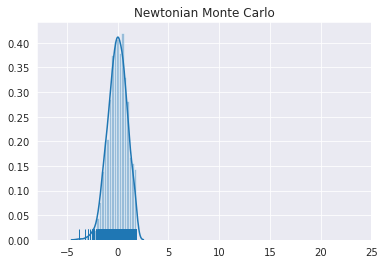

In [18]:
samples = bm.CompositionalInference().infer(
    [x()],
    {},
    num_samples=1000,
    num_chains=1,
)
fig = sns.distplot(samples[x()], rug=True)
fig.set_title("Newtonian Monte Carlo")
fig.set(xlim=(-8,25))
bm.Diagnostics(samples).summary()

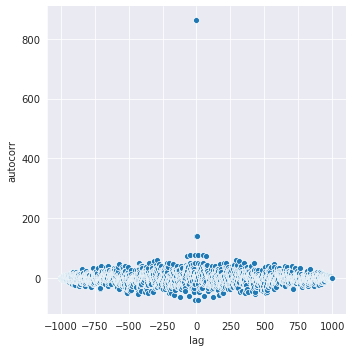

In [16]:
acf(samples)

With RW, we explore the nearby mode, but end up stuck on the larger barrier between second and last component. As a result, there are no samples from the $\mu=15$ component.

,avg,std,2.5%,50%,97.5%,n_eff
x()[],1.559436,2.587444,-1.658532,0.590019,6.725235,14.74826


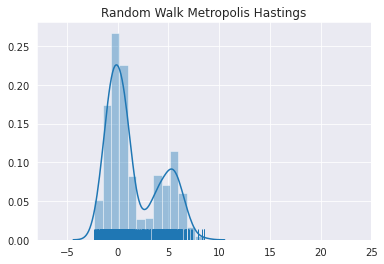

In [17]:
samples = bm.SingleSiteRandomWalk().infer(
    [x()],
    {},
    num_samples=1000,
    num_chains=1,
)
fig = sns.distplot(samples[x()], rug=True)
fig.set(xlim=(-8,25))
fig.set_title("Random Walk Metropolis Hastings")
bm.Diagnostics(samples).summary()

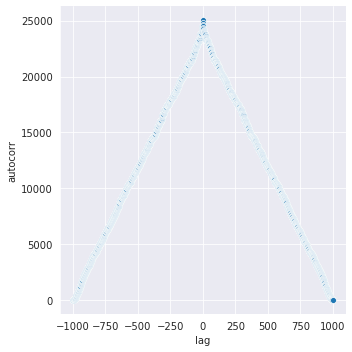

In [433]:
acf(samples)

,avg,std,2.5%,50%,97.5%,n_eff
x()[],1.897252,2.620216,-1.858806,0.914406,6.334954,8.518956


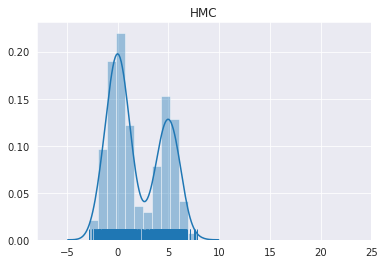

In [19]:
samples = bm.SingleSiteHamiltonianMonteCarlo(
    path_length=1.0,
    step_size=0.1,
).infer(
    [x()],
    {},
    num_samples=1000,
    num_chains=1,
)
fig = sns.distplot(samples[x()], rug=True)
fig.set(xlim=(-8,25))
fig.set_title("HMC")
bm.Diagnostics(samples).summary()

Can IC (1) recover all components and (2) do so with good ESS?

Loss: tensor([53.4971], grad_fn=<AddBackward0>))


[(-8.0, 25.0)]

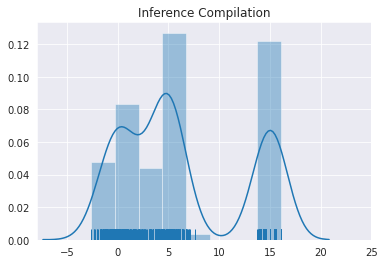

In [20]:
import beanmachine.ppl.experimental.inference_compilation.ic_infer as ic_infer
import torch.optim as optim
import importlib; importlib.reload(ic_infer)

ic = ic_infer.ICInference().compile(
    observation_keys=[],
    query_hints=[x()],
    num_worlds=1e4,
    gmm_num_components=10,
    batch_size=16,
    optimizer_func=lambda x: optim.Adam(x, lr=1e-3, weight_decay=1e-3)
)
samples = ic.infer(
    [x()],
    {},
    num_samples=1000,
    num_chains=1,
)
fig = sns.distplot(samples[x()], rug=True)
fig.set_title("Inference Compilation")
fig.set(xlim=(-8,25))

Here we see higher effective sample size as well as proper inclusion of samples from the $\mu=15$ component.

In [21]:
bm.Diagnostics(samples).summary()

,avg,std,2.5%,50%,97.5%,n_eff
x()[],6.253077,5.951803,-1.43098,4.829874,15.507006,47.183601


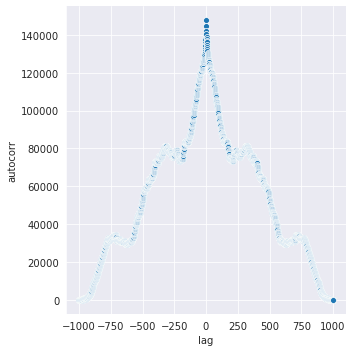

In [452]:
acf(samples)

In [27]:
from beanmachine.ppl.model import StatisticalModel
from beanmachine.ppl.model.utils import Mode

StatisticalModel.set_mode(Mode.INITIALIZE)
node = x()

StatisticalModel.reset()
world = StatisticalModel.get_world()
world.set_observations({})


StatisticalModel.set_mode(Mode.INFERENCE)
world.update_graph(node)
world.accept_diff()

In [28]:
StatisticalModel.set_mode(Mode.INITIALIZE)

node = x()
node_var = world.get_node_in_world(node)

prop = ic._proposers(x()).get_proposal_distribution(
    node,
    node_var,
    world,
    {}
)[0].proposal_distribution.component_distribution.base_dist
prop.loc, prop.scale

(tensor([ 1.2879,  2.6846, -0.1454,  0.0736,  2.1504,  1.3926, -0.0303,  0.0541,
         -0.3001,  1.2969], grad_fn=<SliceBackward>),
 tensor([ 3.1834, 10.5343,  0.6782,  0.7102,  3.6726,  2.7868,  0.7213,  0.6818,
          0.6702,  3.9747], grad_fn=<ClampBackward>))

## PyStan

Stan is also getting stuck in the first two modes!

In [22]:
import pystan

code = """
parameters {
    real y;
}
model {
    target += log_mix(
        [0.3, 0.3, 0.4], [
            normal_lpdf(y | 0, 1.0),
            normal_lpdf(y | 5, 1.0),
            normal_lpdf(y | 15, 0.5)
        ]);
}
"""
sm = pystan.StanModel(model_code=code)
fit = sm.sampling(data={}, iter=1000, chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af3f44580fffab193abea9505f172359 NOW.


[(-8.0, 25.0)]

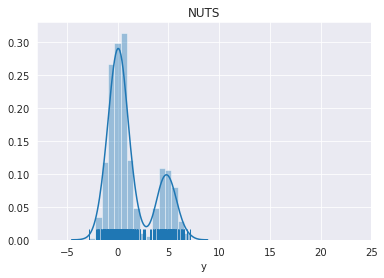

In [24]:
fig = sns.distplot(fit.to_dataframe()["y"], rug=True)
fig.set_title("NUTS")
fig.set(xlim=(-8,25))

In [25]:
print(fit.stansummary())

Inference for Stan model: anon_model_af3f44580fffab193abea9505f172359.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
y      1.21    0.45   2.25  -1.58  -0.37   0.38   2.15    5.8     25   1.01
lp__  -2.49    0.03   0.51  -4.07  -2.59  -2.28  -2.17  -2.12    356    1.0

Samples were drawn using NUTS at Tue Sep  1 00:51:06 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [26]:
import beanmachine.ppl.diagnostics.common_statistics as common_stats